# Fall 2022: DS-GA 1011 NLP with Representation Learning
## Homework 2
## Part 2: Neural Language Modeling (30 pts)
In this assignment, you will build and analyze a neural language model with a recurrent neural network.

In [2]:
# Import required packages
import sys
import os
import json
import numpy as np
from collections import defaultdict
from tqdm import tqdm
import functools

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

---
### 1 LSTM and Hyper-parameters (10 pts)
Your first task is to train a neural recurrent language model on Wikitext-2.

#### Load data

In [3]:
def load_wikitext(filename='wikitext2-sentencized.json'):
    if not os.path.exists(filename):
        !wget "https://nyu.box.com/shared/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json" -O $filename
    
    datasets = json.load(open(filename, 'r'))
    for name in datasets:
        datasets[name] = [x.split() for x in datasets[name]]
    vocab = list(set([t for ts in datasets['train'] for t in ts]))      
    print("Vocab size: %d" % (len(vocab)))
    return datasets, vocab

def perplexity(model, sequences):
    n_total = 0
    logp_total = 0
    for sequence in sequences:
        logp_total += model.sequence_logp(sequence)
        n_total += len(sequence) + 1  
    ppl = 2 ** (- (1.0 / n_total) * logp_total)  
    return ppl

In [4]:
datasets, vocab = load_wikitext()

Vocab size: 33175


#### Utilities

(Hint: you can adopt the `Dictionary`, dataset loading, `Dataloader`, `pad_collate_fn`, and training code from the lab: [**07-rnn_lm.ipynb**](https://drive.google.com/file/d/1scqLM26Njy4ACL9zyIQEVcoP32eTN77i/view?usp=sharing) for use here)

In [5]:
class Dictionary(object): #maps words to indices
    def __init__(self, datasets, include_valid=False):
        self.tokens = []
        self.ids = {}
        self.counts = {}
        
        # add special tokens
        self.add_token('<bos>') #beginning of sentence
        self.add_token('<eos>') #end of sentence
        self.add_token('<pad>')
        self.add_token('<unk>') #unknown. Needed in case use with text with word that isn't in vocab
        
        for line in tqdm(datasets['train']):
            for w in line:
                self.add_token(w)
                    
        if include_valid is True:
            for line in tqdm(datasets['valid']):
                for w in line:
                    self.add_token(w)
                            
    def add_token(self, w):
        if w not in self.tokens:
            self.tokens.append(w)
            _w_id = len(self.tokens) - 1
            self.ids[w] = _w_id
            self.counts[w] = 1
        else:
            self.counts[w] += 1

    def get_id(self, w):
        return self.ids[w]
    
    def get_token(self, idx):
        return self.tokens[idx]
    
    def decode_idx_seq(self, l):
        return [self.tokens[i] for i in l]
    
    def encode_token_seq(self, l):
        return [self.ids[i] if i in self.ids else self.ids['<unk>'] for i in l]
    
    def __len__(self):
        return len(self.tokens)

class TensoredDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """

    def __init__(self, list_of_lists_of_tokens):
        """
        @param hypo_list: list of hypo tokens
        @param prem_list: list of prem tokens
        @param target_list: list of newsgroup targets
        @param max_sentence_length: fixed length of all sentence
        """
        self.input_tensors = []
        self.target_tensors = []
        
        for sample in list_of_lists_of_tokens:
            self.input_tensors.append(torch.tensor([sample[:-1]], dtype=torch.long))
            self.target_tensors.append(torch.tensor([sample[1:]], dtype=torch.long))
        
    def __len__(self):
        return len(self.input_tensors)

    def __getitem__(self, idx):
        """
        Triggered when you call dataset[i]
        """
        return (self.input_tensors[idx], self.target_tensors[idx])

def tokenize_dataset(datasets, dictionary): #substitute words with numbers. Sometimes can include splitting strings, dealing with punctuation and symbols.
    tokenized_datasets = {}
    for split, dataset in datasets.items():
        _current_dictified = []
        for l in tqdm(dataset):
            l = ['<bos>'] + l + ['<eos>']
            encoded_l = dictionary.encode_token_seq(l)
            _current_dictified.append(encoded_l)
        tokenized_datasets[split] = _current_dictified
        
    return tokenized_datasets

def pad_list_of_tensors(list_of_tensors, pad_token):
    max_length = max([t.size(-1) for t in list_of_tensors])
    padded_list = []
    
    for t in list_of_tensors:
        padded_tensor = torch.cat([t, torch.tensor([[pad_token]*(max_length - t.size(-1))], dtype=torch.long)], dim = -1)
        padded_list.append(padded_tensor)
        
    padded_tensor = torch.cat(padded_list, dim=0)
    
    return padded_tensor

def pad_collate_fn(batch, dictionary):
    # batch is a list of sample tuples
    input_list = [s[0] for s in batch]
    target_list = [s[1] for s in batch]
    
    pad_token = dictionary.get_id('<pad>')
    
    input_tensor = pad_list_of_tensors(input_list, pad_token)
    target_tensor = pad_list_of_tensors(target_list, pad_token)
    
    return input_tensor, target_tensor


In [6]:
wikidict = Dictionary(datasets, include_valid=True)
vocab_size = len(wikidict)

print('Vocab Size:', vocab_size)
for i in range(10):
    print(i, wikidict.get_token(i))

100%|██████████| 8464/8464 [00:04<00:00, 1844.53it/s]

Vocab Size: 33181
0 <bos>
1 <eos>
2 <pad>
3 <unk>
4 Valkyria
5 of
6 the
7 Battlefield
8 3
9 )


In [7]:
batch_size = 256
pad_collate = functools.partial(pad_collate_fn, dictionary=wikidict)

wiki_datasets_idxs = tokenize_dataset(datasets, wikidict)
tensored_datasets_idxs = {}

for split, listoflists in wiki_datasets_idxs.items():
    tensored_datasets_idxs[split] = TensoredDataset(listoflists)

split_loaders = {}

for split, wiki_dataset in tensored_datasets_idxs.items():
    split_loaders[split] = DataLoader(wiki_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)


100%|██████████| 9708/9708 [00:00<00:00, 332169.25it/s]


#### Model + Training (5 pts)

In [8]:
from torch.nn import LSTM, Embedding, Linear

class LSTMLanguageModel(nn.Module):
    def __init__(self, options):
        super().__init__()
        
        # create each LM part here 
        self.lookup = nn.Embedding(num_embeddings=options['num_embeddings'], embedding_dim=options['embedding_dim'], padding_idx=options['padding_idx'])
        self.lstm = nn.LSTM(options['embedding_dim'], options['hidden_size'], options['num_layers'], dropout=options['dropout'], batch_first=True)
        self.projection = nn.Linear(options['hidden_size'], options['num_embeddings'])
        
    def forward(self, encoded_input_sequence):
        """
        Forward method process the input from token ids to logits
        """
        # [batch_size, sen_length]
        embeddings = self.lookup(encoded_input_sequence)
        # [batch_size, sen_length, embed_length]
        lstm_outputs = self.lstm(embeddings)
        # [batch_size, sen_length, hidden_dim]
        logits = self.projection(lstm_outputs[0]) #convenient for seq to seq models. check shape of output. lstm gives different
        
        return logits


In [9]:
num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

embedding_size = 256
hidden_size = 256
num_layers = 1
dropout = 0.3

options = {
    'num_embeddings': len(wikidict),
    'embedding_dim': embedding_size,
    'padding_idx': wikidict.get_id('<pad>'),
    'hidden_size': hidden_size,
    'num_layers': num_layers,
    'dropout': dropout,
}


/Users/andrechen/.pyenv/versions/capstone/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [10]:
def check_loss_delta(curr_loss, prev_loss, counter):
    if curr_loss >= prev_loss:
        counter += 1            
    else:
        counter = 0
    return counter

def train_lstm_es(options, split_loaders, m=3, name=''):
    model = LSTMLanguageModel(options).to(current_device)
    model_parameters = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(model_parameters, lr=0.001, momentum=0.999)
    criterion = nn.CrossEntropyLoss(ignore_index=wikidict.get_id('<pad>'))

    train_epoch_losses, val_epoch_losses = ([], [])
    prev_val_loss = sys.maxsize
    bad_epoch_counter = 0

    for epoch_number in range(10):
        avg_loss = 0
        model.train()
        train_log_cache = []
        i = 0
        for (input, target) in tqdm(split_loaders['train'], desc=f'Epoch {epoch_number}', leave=False):
            optimizer.zero_grad()
            input = input.to(current_device)
            target = target.to(current_device)
            logits = model(input)

            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))

            loss.backward()
            optimizer.step()

            train_log_cache.append(loss.item())

            if (i+1) % 100 == 0:
                avg_loss = sum(train_log_cache)/len(train_log_cache)
                train_log_cache = []
            
            i += 1
        
        valid_losses = []
        model.eval()
        with torch.no_grad():
            for i, (input, target) in enumerate(split_loaders['valid']):
                input = input.to(current_device)
                target = target.to(current_device)
                logits = model(input)

                loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
                valid_losses.append(loss.item())
            
        avg_val_loss = sum(valid_losses) / len(valid_losses)
        
        if check_loss_delta(avg_val_loss, prev_val_loss, bad_epoch_counter) == m:
            break # Early stopping
    
        prev_val_loss = avg_val_loss
        train_epoch_losses.append(avg_loss)
        val_epoch_losses.append(avg_val_loss)

        checkpoint = f'{name}_model_{epoch_number}.pt'
        torch.save(model.cpu().state_dict(), checkpoint) # saving model
        model.cuda()
    
    best_val_idx = val_epoch_losses.index(np.min(val_epoch_losses))
    for i in range(len(val_epoch_losses)):
        if i != best_val_idx:
            os.remove(f'{name}_model_{i}.pt')
        
    return train_epoch_losses, val_epoch_losses

train_lstm_es(options, split_loaders, m=3)

Epoch 0:   1%|▏         | 10/783 [00:15<19:21,  1.50s/it]


KeyboardInterrupt: 

#### Performance variation based on hyper-parameter values (5 pts)


In [ ]:
h_sizes = [64, 128, 256, 512]

h_size_results = {}

for h_size in h_sizes:
    options = {
        'num_embeddings': len(wikidict),
        'embedding_dim': embedding_size,
        'padding_idx': wikidict.get_id('<pad>'),
        'hidden_size': h_size,
        'num_layers': num_layers,
        'dropout': dropout,
    }

    h_size_results[h_size] = train_lstm_es(options, split_loaders, m=3, name=f'hidden_{h_size}')

h_size_results

---
### 2 Learned embeddings (6 pts)
Next you will analyze the word embeddings that the model learns.


#### Utilities

Below is code to use [UMAP](https://umap-learn.readthedocs.io/en/latest/) to find a 2-dimensional representation of a weight matrix, and plot the resulting 2-dimensional points that correspond to certain words.

Use `!pip install umap-learn` to install UMAP.

In [ ]:
%pylab inline 
import umap
import matplotlib.pyplot as plt

def umap_plot(weight_matrix, word_ids, words):
    """Run UMAP on the entire Vxd `weight_matrix` (e.g. model.lookup.weight or model.projection.weight),
    And plot the points corresponding to the given `word_ids`. """
    reduced = umap.UMAP(min_dist=0.0001).fit_transform(weight_matrix.detach().cpu().numpy())
    plt.figure(figsize=(10,10))

    to_plot = reduced[word_ids, :]
    plt.scatter(to_plot[:, 0], to_plot[:, 1])
    for i, word_id in enumerate(word_ids):
        current_point = to_plot[i]
        plt.annotate(words[i], (current_point[0], current_point[1]))

    plt.grid()
    plt.show()

Populating the interactive namespace from numpy and matplotlib


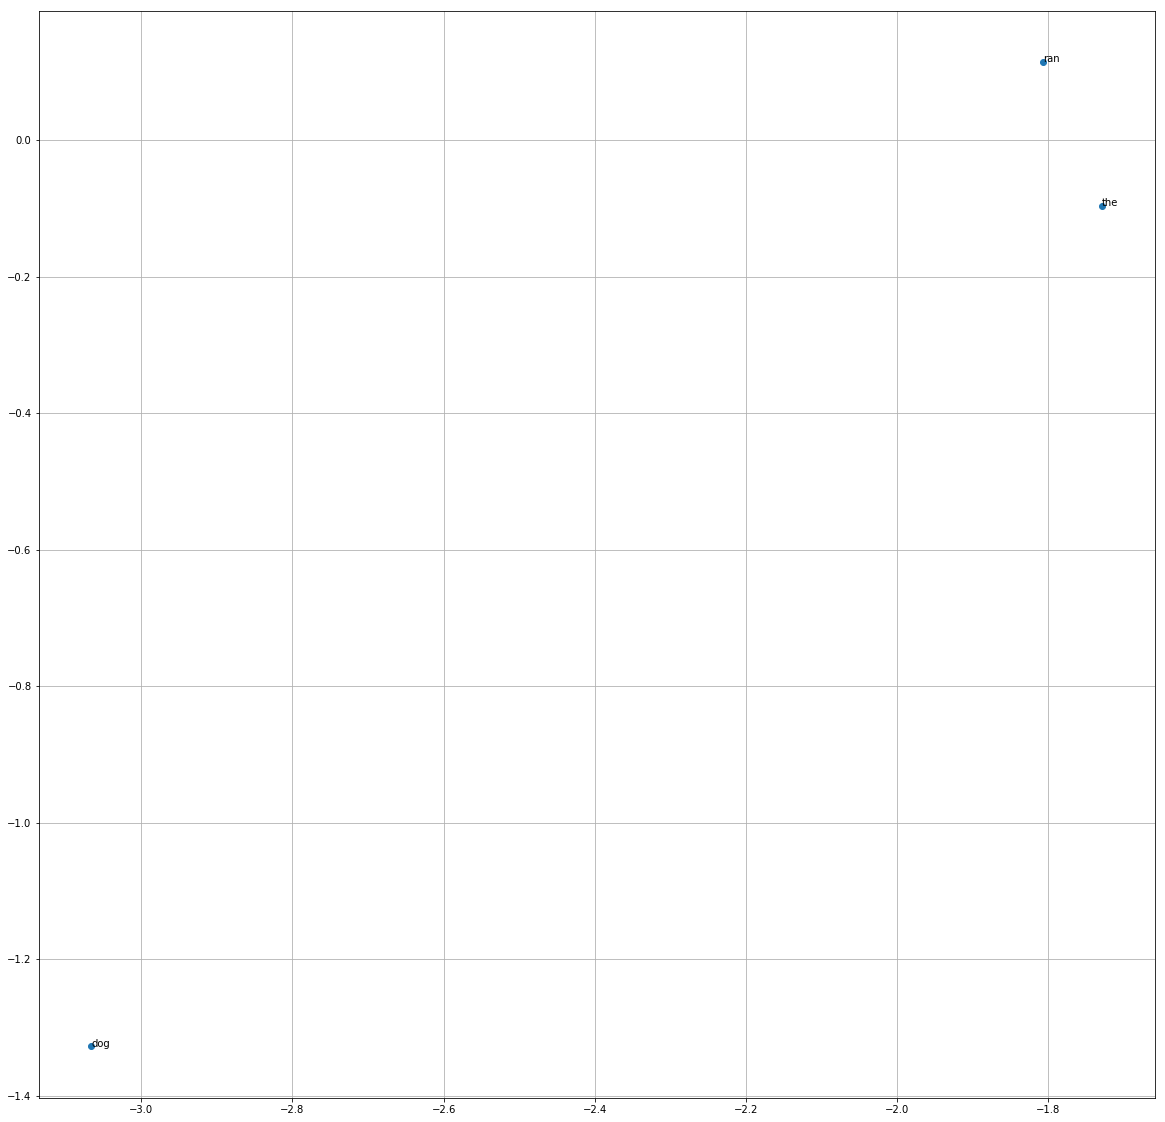

In [ ]:
Vsize = 100                                 # e.g. len(dictionary)
d = 32                                      # e.g. model.lookup.weight.size(1) 
fake_weight_matrix = torch.randn(Vsize, d)  # e.g. model.lookup.weight

words = ['the', 'dog', 'ran']
word_ids = [4, 54, 20]                  # e.g. use dictionary.get_id on a list of words

umap_plot(fake_weight_matrix, word_ids, words)

#### 2.1 Word similarity (3 pts)


#### 2.2 UMAP (3 pts)

---
### 3 Sampling (14 pts)


#### 3.1 Sampling implementation (4 pts)

#### 3.2 1,000 samples and average log probability implementation (4 pts)

#### 3.3 Number of unique tokens and sequence length (3 pts)

(1,000 samples vs. 1,000 randomly selected validation-set sequences)


#### 3.4 Example samples (3 pts)